[*********************100%***********************]  3 of 3 completed



MULTI-ASSET PORTFOLIO OPTIMIZATION REPORT
Optimization Target: 9.0% Annual Return
--------------------------------------------------

1. ASSET ALLOCATION
Gold (ETF)                : 19.5%
Fixed Income (Liquid)     : 63.6%
Equity (NIFTY 50)         : 16.9%

2. PERFORMANCE METRICS
Metric               | Benchmark (Equity)   | Optimized Portfolio 
------------------------------------------------------------------
Annual Return        | 16.4%               | 9.0%
Volatility (Risk)    | 12.8%               | 3.4%
Sharpe Ratio         | 1.28                 | 2.63
------------------------------------------------------------------
Risk Reduction Achieved : 73.3%
Value at Risk (95% Daily): -0.32%



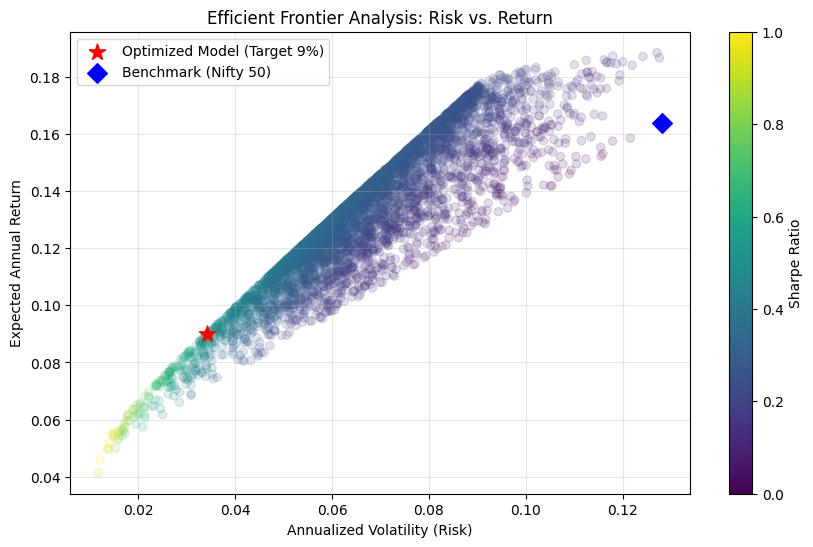

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

assets = ['NIFTYBEES.NS', 'GOLDBEES.NS', 'LIQUIDBEES.NS']
labels = ['Equity (NIFTY 50)', 'Gold (ETF)', 'Fixed Income (Liquid)']
target_return = 0.09

data = yf.download(assets, period="5y", auto_adjust=True)['Close']
data = data.dropna()

returns = data.pct_change().dropna()
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

def portfolio_stats(weights):
    weights = np.array(weights)
    p_ret = np.sum(mean_daily_returns * weights) * 252
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return p_ret, p_vol

def min_volatility(weights):
    return portfolio_stats(weights)[1]

constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'eq', 'fun': lambda x: portfolio_stats(x)[0] - target_return}
)
bounds = tuple((0, 1) for _ in range(len(assets)))
init_guess = [1/3, 1/3, 1/3]

opt_result = sco.minimize(min_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = opt_result.x
opt_ret, opt_vol = portfolio_stats(opt_weights)

bench_ret = mean_daily_returns['NIFTYBEES.NS'] * 252
bench_vol = returns['NIFTYBEES.NS'].std() * np.sqrt(252)

risk_reduction = 1 - (opt_vol / bench_vol)
var_95 = (opt_ret / 252) - (1.65 * (opt_vol / np.sqrt(252)))

print("\n" + "="*50)
print(f"MULTI-ASSET PORTFOLIO OPTIMIZATION REPORT")
print("="*50)
print(f"Optimization Target: {target_return:.1%} Annual Return")
print("-" * 50)

print("\n1. ASSET ALLOCATION")
for asset_col, weight in zip(data.columns, opt_weights):
    label = next((l for a, l in zip(assets, labels) if a == asset_col), asset_col)
    print(f"{label:<25} : {weight:.1%}")

print("\n2. PERFORMANCE METRICS")
print(f"{'Metric':<20} | {'Benchmark (Equity)':<20} | {'Optimized Portfolio':<20}")
print("-" * 66)
print(f"{'Annual Return':<20} | {bench_ret:.1%}{'':<14} | {opt_ret:.1%}")
print(f"{'Volatility (Risk)':<20} | {bench_vol:.1%}{'':<14} | {opt_vol:.1%}")
print(f"{'Sharpe Ratio':<20} | {(bench_ret/bench_vol):.2f}{'':<16} | {(opt_ret/opt_vol):.2f}")

print("-" * 66)
print(f"Risk Reduction Achieved : {risk_reduction:.1%}")
print(f"Value at Risk (95% Daily): {var_95:.2%}")
print("="*50 + "\n")

num_sims = 5000
results = np.zeros((2, num_sims))
for i in range(num_sims):
    w = np.random.random(len(assets))
    w /= np.sum(w)
    r, v = portfolio_stats(w)
    results[0,i] = r
    results[1,i] = v

plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=(results[0,:]/results[1,:]), cmap='viridis', alpha=0.15)
plt.scatter(opt_vol, opt_ret, c='red', s=150, marker='*', label=f'Optimized Model (Target {target_return:.0%})')
plt.scatter(bench_vol, bench_ret, c='blue', s=100, marker='D', label='Benchmark (Nifty 50)')
plt.title('Efficient Frontier Analysis: Risk vs. Return')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Expected Annual Return')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()